In [1]:
suppressMessages(library(ggplot2))
suppressMessages(library(ggView))
suppressMessages(library(MAGeCKFlute))
suppressMessages(library(rcompanion))

In [2]:
Kinase_lists  = readRDS("data/All_engaged.rds")
Degradability = readRDS("data/Donovan_Degradability.rds")
Lysines = read.table("data/Lysine_E2_Accessibility.txt", sep = "\t", header = TRUE)

In [3]:
TotalUbs = as.data.frame(table(Lysines$GeneID[grepl("ub", Lysines$MOD_RSD)]))
TotalLys = as.data.frame(table(Lysines$GeneID[Lysines$MOD_RSD=="K"]))
Summary = merge(TotalLys, TotalUbs, by = "Var1", all = TRUE)
colnames(Summary) = c("Gene", "TotalLys", "TotalUB")

for(filter in seq(0,1,0.1)){
    idx = Lysines$E2_accessible_orientation>=filter
    AccUbs = as.data.frame(table(Lysines$GeneID[idx & grepl("ub", Lysines$MOD_RSD)]))
    AccLys = as.data.frame(table(Lysines$GeneID[idx & Lysines$MOD_RSD=="K"]))
    colnames(AccLys) = c("Gene", paste0("Lysine_", filter))
    colnames(AccUbs) = c("Gene", paste0("UbSite_", filter))
    Summary = merge(Summary, AccLys, by = "Gene", all = TRUE)
    Summary = merge(Summary, AccUbs, by = "Gene", all = TRUE)
    Summary[is.na(Summary)] = 0
}
Summary = Summary[Summary$Lysine_0>0, ]
head(Summary)

,Gene,TotalLys,TotalUB,Lysine_0,UbSite_0,Lysine_0.1,UbSite_0.1,Lysine_0.2,UbSite_0.2,Lysine_0.3,⋯,Lysine_0.6,UbSite_0.6,Lysine_0.7,UbSite_0.7,Lysine_0.8,UbSite_0.8,Lysine_0.9,UbSite_0.9,Lysine_1,UbSite_1
,<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,AAK1,16,1,16,1,13,1,13,1,8,⋯,7,0,6,0,3,0,0,0,0,0
2,ABL1,17,0,17,0,14,0,11,0,10,⋯,1,0,0,0,0,0,0,0,0,0
3,ABL2,17,0,17,0,16,0,9,0,6,⋯,4,0,3,0,0,0,0,0,0,0
4,ACVR1,14,0,14,0,10,0,9,0,8,⋯,4,0,3,0,1,0,0,0,0,0
5,ACVR2A,17,0,17,0,15,0,11,0,8,⋯,4,0,1,0,0,0,0,0,0,0
6,ACVR2B,15,1,15,1,13,1,10,0,6,⋯,3,0,1,0,0,0,0,0,0,0


In [4]:
tmpdat = Summary[Summary$Gene%in%unlist(Kinase_lists), ]
tmpdat$Group = "low"
tmpdat$Group[tmpdat$Gene%in%Kinase_lists$degraded] = "high"
table(tmpdat$Group)

LysineZ = apply(tmpdat[, grepl("UbSite|Lysine", colnames(tmpdat))], 2, function(x){
    tmp = suppressWarnings(wilcoxonZ(x[tmpdat$Group=="high"], x[tmpdat$Group=="low"]))
})


high  low 
  40   38 

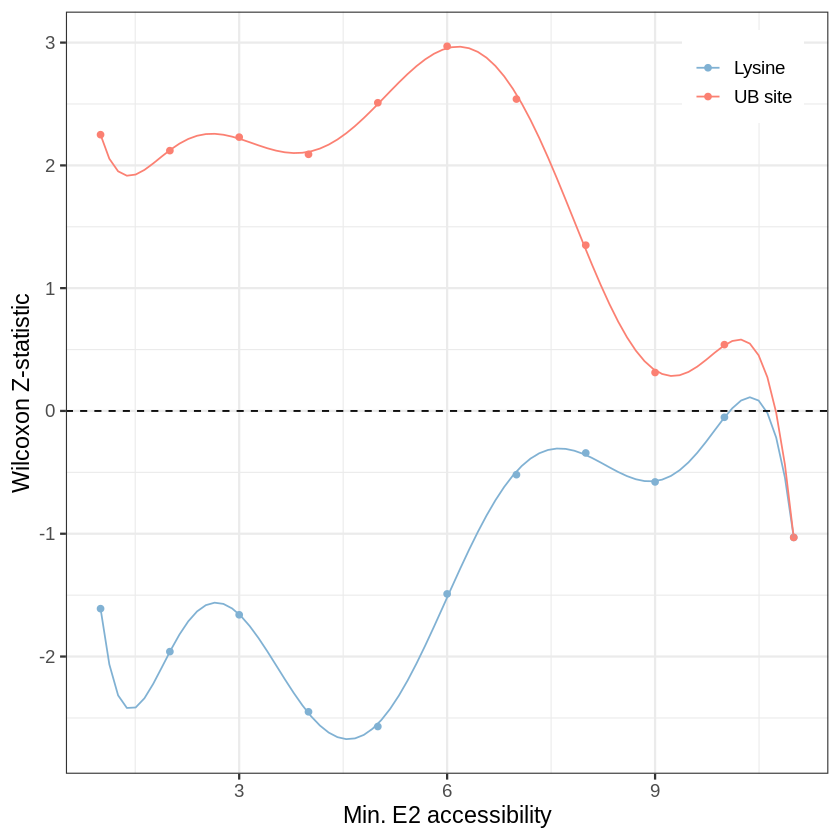

In [5]:
gg = data.frame(Term = names(LysineZ), Type = gsub("_.*", "", names(LysineZ)), 
                Accessibility = gsub(".*_", "", names(LysineZ)), Zscore = LysineZ)
gg$Accessibility = as.numeric(gg$Accessibility)
p = ggplot(gg, aes(Accessibility, Zscore, color = Type))
p = p + geom_point()
p = p + stat_smooth(method = "lm", formula = y ~ poly(x, 8), size = 0.5, se = FALSE)
p = p + scale_color_manual(values = c("#80b1d3", "#fb8072"), labels = c("Lysine", "UB site"))
p = p + theme_bw(base_size = 14)
p = p + geom_hline(yintercept = 0, linetype = "dashed")
p = p + labs(x = "Min. E2 accessibility", y = "Wilcoxon Z-statistic", color = NULL)
p = p + theme(legend.position = c(1,1), legend.justification = c(1.2,1.2))
p

In [6]:
AccUBs_BG = sapply(unique(Lysines$GeneID), function(g){
    K_idx = which(Lysines$GeneID==g & Lysines$MOD_RSD=="K")
    nUB = sum(Lysines$GeneID==g & grepl("ub$", Lysines$MOD_RSD))
    sapply(1:10000, function(i){
        ridx = sample(K_idx, nUB)
        sum(Lysines$E2_accessible_orientation[ridx]>=0.5)
    })
})
AccUBs_BG = AccUBs_BG[, tmpdat$Gene]
Effects = apply(AccUBs_BG, 1, function(x){
    wilcoxonZ(x[tmpdat$Group=="high"], x[tmpdat$Group=="low"])
})

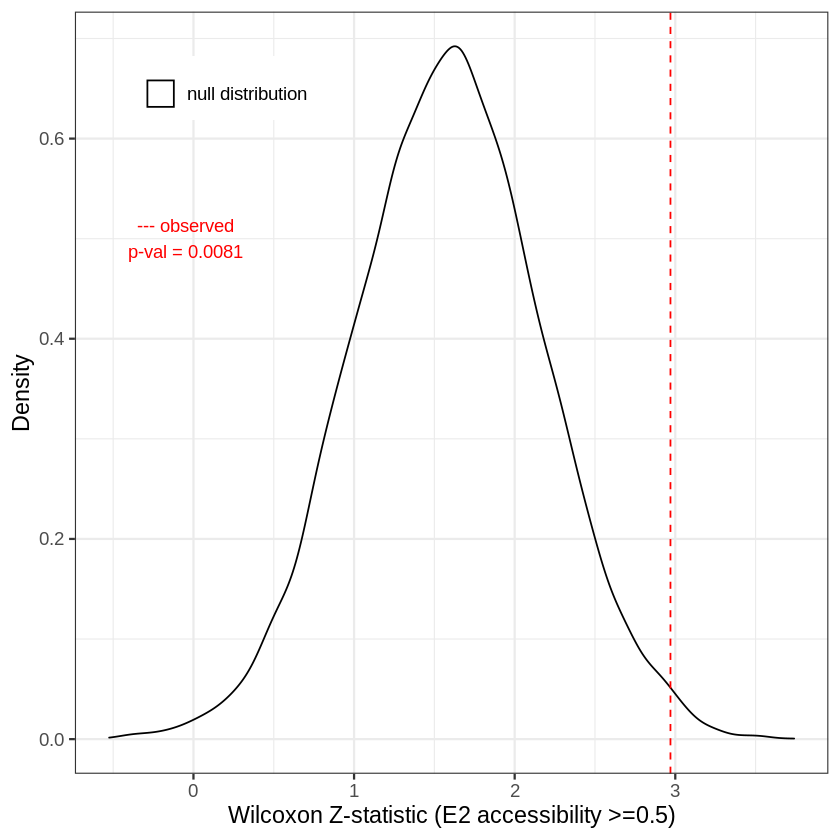

In [7]:
Observed = wilcoxonZ(tmpdat$`UbSite_0.5`[tmpdat$Group=="high"], tmpdat$`UbSite_0.5`[tmpdat$Group=="low"])
gg = data.frame(Effect = Effects)
p = ggplot(gg, aes(x = Effect, color = "null distribution"))
p = p + geom_density(size = 0.5)
p = p + scale_color_manual(values = c("black"))
p = p + geom_vline(xintercept = Observed, color = "red", linetype = "dashed", size = 0.5)
pval = sum(Effects>Observed) / 10000
p = p + annotate("text", x = -0.05, y = 0.5, label = paste0("--- observed\n", "p-val = ", pval), color = "red")
p = p + labs(x = "Wilcoxon Z-statistic (E2 accessibility >=0.5)", y = "Density", color = NULL)
p = p + theme_bw(base_size = 14)
p = p + theme(legend.position = c(0.2,0.9))
p

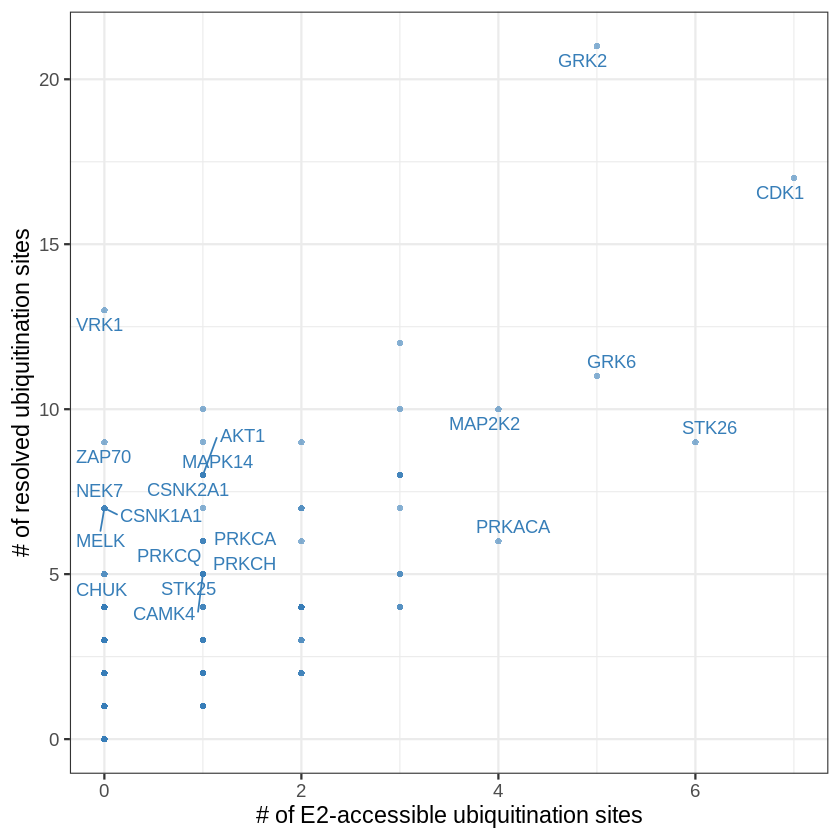

In [8]:
toplabels = Summary$Gene[Summary$TotalUB>4 & Summary$UbSite_0.5<2]
toplabels = intersect(toplabels, Degradability$Gene[Degradability$UniqDegradeFreq<1])
toplabels = c(toplabels, "MAPK14", "AKT1", "CSNK1A1")
p = ScatterView(Summary, "UbSite_0.5", "TotalUB", label = "Gene", color = "#377eb8", toplabels = toplabels,
                size = 1.5, x_cut = 3, y_cut = 3, groups = c("topright"), top = 20, max.overlaps = Inf)
p = p + labs(x = "# of E2-accessible ubiquitination sites", y = "# of resolved ubiquitination sites")
p = p + theme_bw(base_size = 14)
p = p + theme(legend.position = "none")
p